# MCMC using backward filtering, forward guiding for shapes

Parameter inference for trees with Gaussian transitions along edges and observations at the leaf nodes for landmark represented shapes. Please refer to the notebook [mcmc_Gaussian_BFFG.ipynb](mcmc_Gaussian_BFFG.ipynb) for a simpler version with $\mathbb R^2$ data. In the present version, the node covariance is constant throughout the tree similarly to [mcmc_Gaussian_BFFG.ipynb](mcmc_Gaussian_BFFG.ipynb). Shape dependent node covariance will follow in a later version.

The conditioning and upwards/downwards message passing and fusing operations follow the backward filtering, forward guiding approach of Frank van der Meulen, Moritz Schauer et al., see https://arxiv.org/abs/2010.03509 and https://arxiv.org/abs/2203.04155 . The latter reference provides an accesible introduction to the scheme and the notation used in this example.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update("jax_enable_x64", True)
from jax import numpy as jnp
from jax.random import PRNGKey, split

from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda, UpLambda

from hyperiax.tree.topology import symmetric_topology
from hyperiax.tree import HypTree

from hyperiax.plotting import plot_tree_text, plot_tree_2d_scatter, plot_tree_2d_shape, plot_shape_2d

from hyperiax.mcmc import ParameterStore, VarianceParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.plotting import trace_plots

from examples.ABFFG import *
from examples.shape import k_K2

import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# seed,
#seed = 42
import os; seed = int(os.urandom(5).hex(), 16)
print("seed: ",seed)
key = PRNGKey(seed)

seed:  513714401784


# Shape related setup

<Axes: >

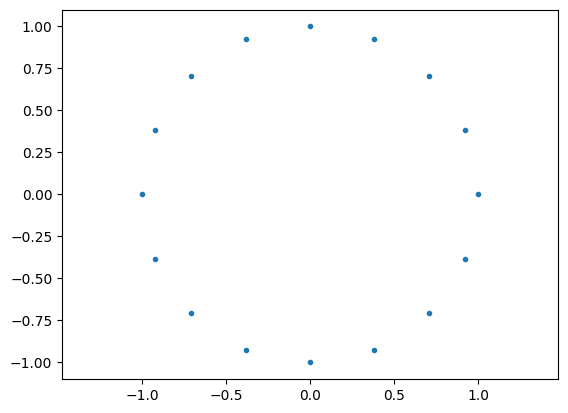

In [4]:
# define shape and plot
d = 2; n = 16 # d = dimension of embedding space (usually 2), n = number of landmarkds
phis = jnp.linspace(0,2*jnp.pi,n,endpoint=False) # circular shape
root = jnp.vstack((jnp.cos(phis),jnp.sin(phis))).T.flatten()

# plot
plot_shape_2d(root)

In [5]:
# diffusion and covariance specification for shape processes
kQ12 = lambda x,params: (1/n)*k_K2(x,params)

# evaluate k on two pairs of landmark configurations
kQ12_q = lambda q1,q2,params: kQ12(q1.reshape((-1,d))[:,jnp.newaxis,:]-q2.reshape((-1,d))[jnp.newaxis,:,:],params)

# evaluate k on one landmark configurations against itself with each landmark pair resulting in a dxd matric
# i,jth entry of result is kQ12(x_i,x_j)*eye(d)
def Q12(q,params): 
    A = jnp.einsum('ij,kl->ikjl',kQ12_q(q,q,params),jnp.eye(2))
    return A.reshape((A.shape[0]*A.shape[1],A.shape[2]*A.shape[3]))

# diffusion matrix
sigma = lambda _,params: Q12(root,params)
# covariance matrix
def a(_,params): _sigma = sigma(_,params); return jnp.einsum('ij,kj->ik',_sigma,_sigma)

# Gaussian tree, constant node covariance

First, we initialize the tree. We set the root to the shape defined above.

In [6]:
# create topology and tree
topology = symmetric_topology(height=2, degree=5)
plot_tree_text(topology)
tree = HypTree(topology)
print(tree)

# add properties to tree
tree.add_property('edge_length', shape=())
# data dimension
d = 2
tree.add_property('value', shape=(n*d,))
tree.add_property('noise', shape=(n*d,))

# set edge lengths on all nodes
tree.data['edge_length'] = jnp.ones_like(tree.data['edge_length'])

# root value
tree.data['value'] = tree.data['value'].at[0].set(root)

                                                            None
           ┌────────────────────────┬────────────────────────┼────────────────────────┬────────────────────────┐
          None                     None                     None                     None                     None          
 ┌────┬────┼────┬────┐    ┌────┬────┼────┬────┐    ┌────┬────┼────┬────┐    ┌────┬────┼────┬────┐    ┌────┬────┼────┬────┐  
None None None None None None None None None None None None None None None None None None None None None None None None None
HypTree(size=31, levels=3, leaves=25, inner nodes=5)


We then define parameters for the Gaussian transition kernel.

In [7]:
# parameters, variance and observation noise
params = ParameterStore({
    'k_alpha': VarianceParameter(.1), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.5), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3) # observation noise variance
    })

Now follows the down transitions. At first, we define the unconditional transitions, which are just Gaussian samples. The covariance is sqare of the pairwise kernel evaluations in `sigma(params)` times the variance parameter times edge lengths.

In [8]:
# unconditional down
down_unconditional = Gaussian_down_unconditional(sigma)

We can now draw noise and perform a downwards pass. This gives values at all nodes of the tree. Note that observation noise is not added to the leaves yet.

In [9]:
subkey, key = split(key)
update_noise(tree,subkey)
down_unconditional.down(tree,params.values())

Add uncorrelated observation noise to leaves.



In [10]:
# add noise to leaf nodes
key, subkey = split(key)
add_leaf_noise(tree,key,params)
leaf_values = tree.data['value'][tree.is_leaf]

Plot a generated tree.

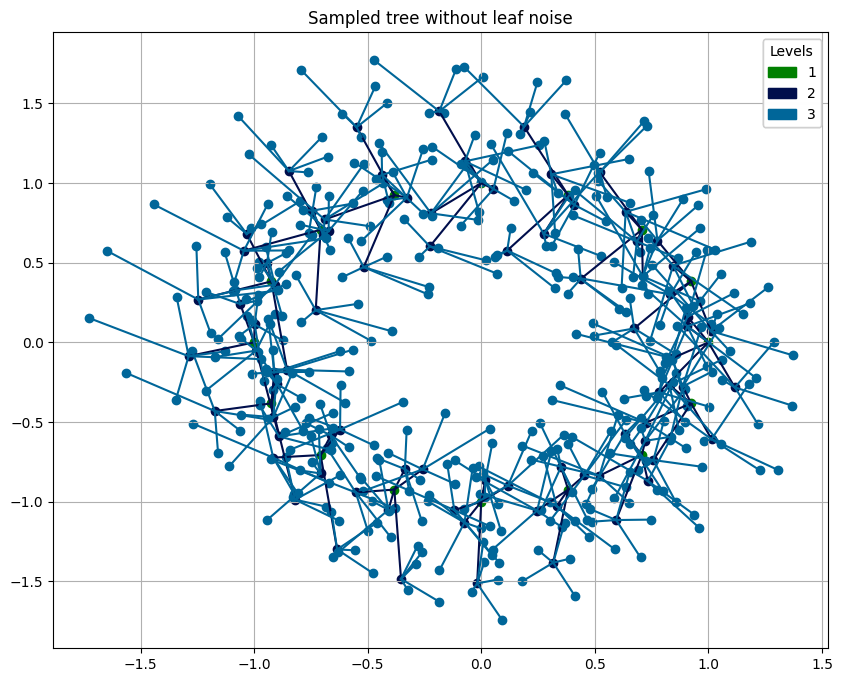

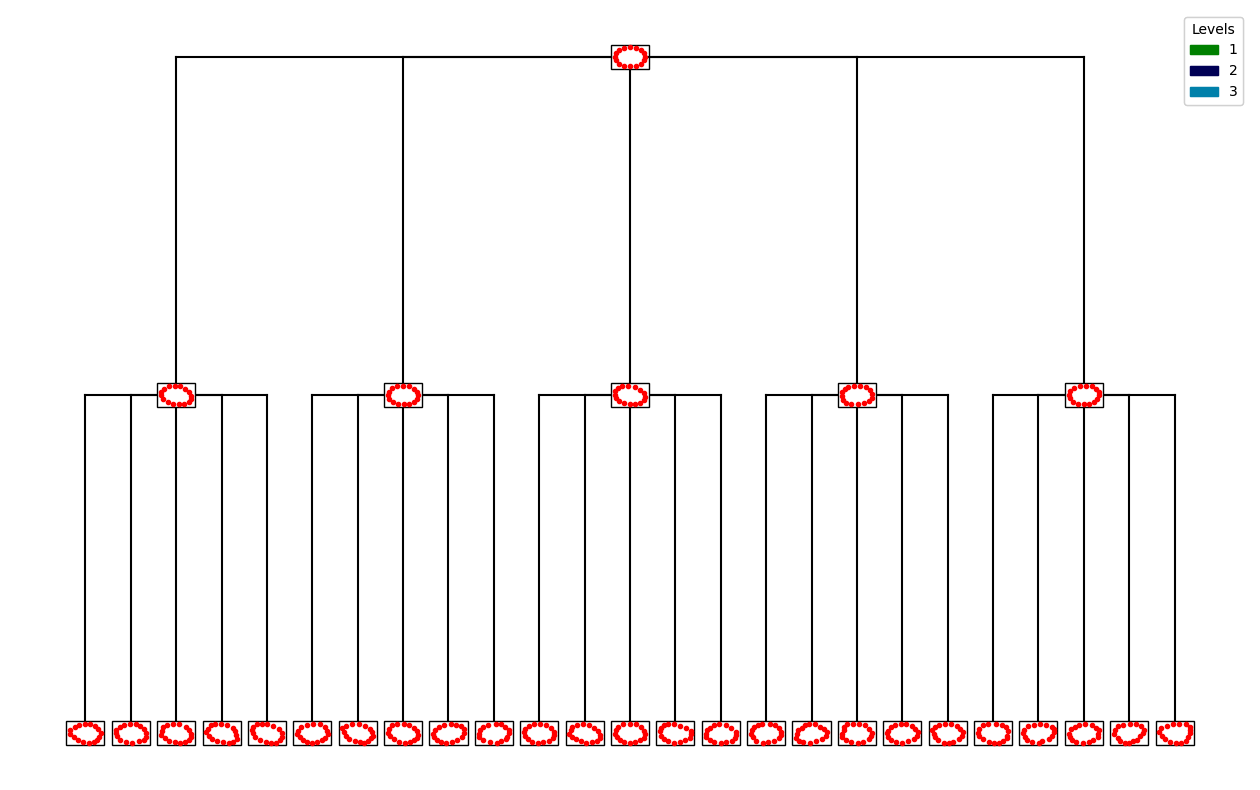

In [11]:
fig,ax = plt.subplots(figsize=(10,8))
plot_tree_2d_scatter(tree,'value',selector=lambda z: z.reshape((n,d)),ax=ax)
plt.gca().set_title('Sampled tree without leaf noise')

plot_tree_2d_shape(tree,'value')

# Backwards filtering, forward guiding

We now define the backwards filter through the up function. The Gaussian are parametrized in the $(c,F,H)$ format make the fuse just a sum of the results of the up operation. See https://arxiv.org/abs/2203.04155 for details.

In [12]:
# backwards filter
up = Gaussian_up(n*d,a)

We initialize the tree for up by computing the $c,F,H$-values at the leaves.

In [13]:
# initialize tree
init_up = get_init_up(n*d,tree)

We can now define the conditional downwards pass, i.e. the forwards guiding.

In [14]:
# conditional down
down_conditional = Gaussian_down_conditional(n*d,a)

We make an upwards pass and a downwards conditional sampling to test. Subsequently, we time the three operations (uncondtional down, conditional down, and up).

In [15]:
# backwards filter and fowards guiding, time the operations
test_up_down(down_unconditional,down_conditional,up,init_up,tree,params,leaf_values,key)

Time elapsed: 0.0892 ms
Time elapsed: 1.9119 ms
Time elapsed: 1.0769 ms


In [16]:
tree.data['value'].shape

(31, 32)

We test the setup by sampling a number of trees and computing mean and covariance of the leaf data.

In [17]:
# do statistics on the leaf values
F = tree.data['F_T'][0]; H = tree.data['H_T'][0]
print("root conditional mean vs. sample mean:",jnp.linalg.solve(H,F),jnp.mean(leaf_values,0))
print("root conditional cov vs. sample cov:",jnp.linalg.inv(H),jnp.cov(leaf_values.T))

# sample statistics
K = 500 # number samples
samples = jnp.zeros((K,sum(tree.is_leaf),n*d))
samples_noise = jnp.zeros((K,sum(tree.is_leaf),n*d))
samples_conditional = jnp.zeros((K,sum(tree.is_leaf),n*d))

for i in tqdm(range(K)):
    subkey, key = split(key)
    update_noise(tree,subkey)
    down_unconditional.down(tree,params.values())
    values = tree.data['value'][tree.is_leaf]
    # collect values
    samples = samples.at[i].set(values)
    # add observation noise
    subkey,key = jax.random.split(key)
    samples_noise = samples_noise.at[i].set(values+jnp.sqrt(params['obs_var'].value)*jax.random.normal(subkey,values.shape))
    # conditional sampling
    update_noise(tree,subkey)
    down_conditional.down(tree,params.values())
    samples_conditional = samples_conditional.at[i].set(tree.data['value'][tree.is_leaf])
# print sample statistics for all leaves
print("data parameters: ",params.values())
print("observation noise: ")
print(" mean: ",jnp.mean(samples_conditional-leaf_values,axis=(0,1)))
print(" cov: ",jnp.cov((samples_conditional-leaf_values).reshape(-1,n*d).T))
print("leaves: ")
for i in range(samples.shape[1]):
    print("  mean: ",jnp.mean(samples[:,i],0))
    print("  cov: ",jnp.cov(samples[:,i].T))
    print("  mean w/ noise: ",jnp.mean(samples_noise[:,i],0))
    print("  cov w/ noise: ",jnp.cov(samples_noise[:,i].T))
    print("  mean conditional: ",jnp.mean(samples_conditional[:,i],0), ", sample: ",leaf_values[i])
    print("  cov conditional: ",jnp.cov(samples_conditional[:,i].T))
    print("  mean noise: ",jnp.mean(samples_conditional[:,i]-leaf_values[i],0))
    print("  cov noise: ",jnp.cov((samples_conditional[:,i]-leaf_values[i]).T))

root conditional mean vs. sample mean: [ 0.9212389  -0.06188519  0.85476349  0.33498547  0.64485078  0.70677158
  0.30292327  0.97737707 -0.08423276  1.06192903 -0.47922945  0.97972511
 -0.77600708  0.73296924 -0.97367059  0.39121674 -1.03230681 -0.02754362
 -0.92007822 -0.42001239 -0.70295622 -0.76796927 -0.38171084 -0.9878419
 -0.00230393 -1.07235641  0.33111386 -0.99761781  0.64766172 -0.78868532
  0.8515469  -0.45247469] [ 0.9212389  -0.06188519  0.85476349  0.33498547  0.64485078  0.70677158
  0.30292327  0.97737707 -0.08423276  1.06192903 -0.47922945  0.97972511
 -0.77600708  0.73296924 -0.97367059  0.39121674 -1.03230681 -0.02754362
 -0.92007822 -0.42001239 -0.70295622 -0.76796927 -0.38171084 -0.9878419
 -0.00230393 -1.07235641  0.33111386 -0.99761781  0.64766172 -0.78868532
  0.8515469  -0.45247469]
root conditional cov vs. sample cov: [[ 0.00667753  0.          0.00648189 ...  0.          0.00648189
   0.        ]
 [ 0.          0.00667753  0.         ...  0.00606088  0.
   0.

100%|██████████| 500/500 [00:01<00:00, 368.34it/s]


data parameters:  {'k_alpha': 0.1, 'k_sigma': 0.5, 'obs_var': 0.001}
observation noise: 
 mean:  [ 4.75152878e-03 -2.91349767e-03 -2.59504499e-05  9.68868659e-03
 -6.70143022e-03  3.26492109e-03  2.89982805e-03 -1.11120536e-02
 -2.32140626e-03  1.01949374e-05  8.95370351e-03 -2.31079422e-04
 -6.03708430e-03  5.83156256e-03 -2.06207382e-03 -5.66696767e-03
  6.71542112e-03  4.85050411e-03 -7.44416064e-03 -5.10807513e-03
  3.37244713e-03  4.36799081e-03  2.88724997e-03 -1.76245182e-03
 -1.20316806e-02  9.17336093e-04  1.12129343e-02 -1.33483901e-03
 -3.63096072e-03  4.45582222e-03 -2.02644606e-03 -5.81733019e-03]
 cov:  [[ 1.01103784e-03  1.48122091e-04 -5.72032686e-05 ...  3.11242243e-04
  -5.73853964e-05 -1.65371163e-04]
 [ 1.48122091e-04  1.09232350e-03  9.58052885e-06 ...  2.34334582e-04
  -8.31240808e-05 -1.79346058e-04]
 [-5.72032686e-05  9.58052885e-06  1.15705343e-03 ...  5.98315613e-07
   3.97093437e-05 -1.74750801e-05]
 ...
 [ 3.11242243e-04  2.34334582e-04  5.98315613e-07 ...  

# MCMC

MCMC for parameter estimation. In this case, with constant node covariance the model is fully Gaussian and we can use the result of upwards pass without correction (logw is zero).

Initial parameters:  {'k_alpha': 0.1, 'k_sigma': 0.1, 'obs_var': 0.001}
data parameters:  {'k_alpha': 0.1, 'k_sigma': 0.5, 'obs_var': 0.001}


100%|██████████| 2000/2000 [00:25<00:00, 78.92it/s]


Acceptance rate: 0.8370


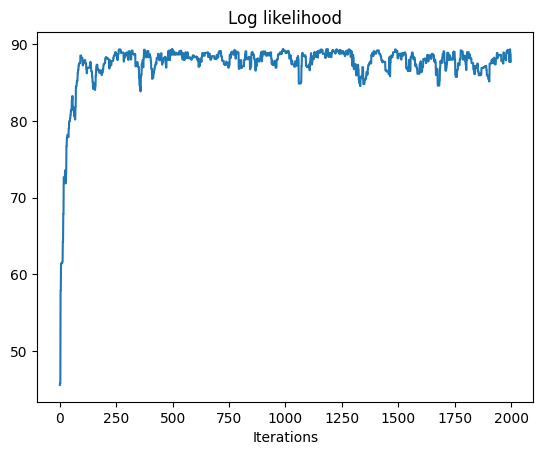

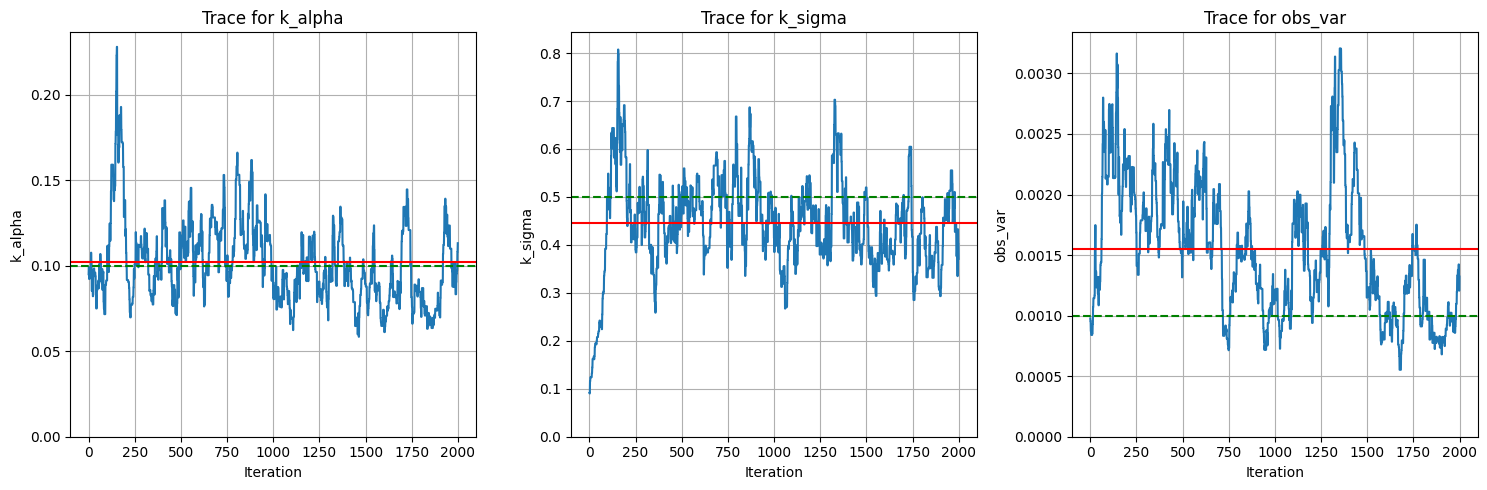

In [18]:
log_likelihood = get_log_likelihood(tree,down_conditional,up,init_up)
log_posterior = get_log_posterior(log_likelihood)
proposal = get_proposal(tree)

# tree values and parameters
init_params = ParameterStore({
    'k_alpha': VarianceParameter(.1,alpha=3,beta=.5), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.1), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3,min=1e-4,max=.1,prior='uniform') # observation noise variance
    })
print("Initial parameters: ",init_params.values())
print("data parameters: ",params.values())

# initial state
init_state = (init_params,(jnp.zeros_like(tree.data['noise']),tree.data['v_T']))

# Run Metropolis-Hastings
subkey, key = split(key)
log_likelihoods, samples = metropolis_hastings(log_posterior, proposal, leaf_values, init_state, 2000, burn_in=000, rng_key=key, savef=lambda state: state[0])

# plot
plt.plot(log_likelihoods)
plt.xlabel("Iterations")
plt.title('Log likelihood')
trace_plots(samples,true_params=params.values())